In [0]:
from google.colab import files
import matplotlib.pyplot as plt
from scipy.linalg import circulant
import numpy as np
import time
from sklearn.decomposition import FastICA, PCA
from google.colab import drive
import imageio

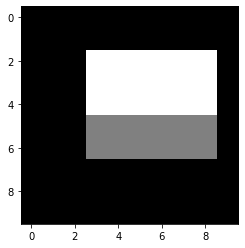

In [3]:
pic1 = np.zeros((10,10))
pic1[2:7,3:9] = 1

pic1[5:7, 3:9] = 0.5
plt.imshow(pic1,'gray')

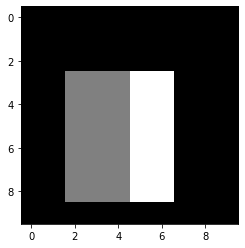

In [0]:

pic2 = np.zeros((10,10))
pic2[3:9,2:7] = 0.5

pic2[3:9, 5:7] = 1
plt.imshow(pic2,'gray')

In [4]:
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py -O mnist.py

--2020-05-11 09:02:34--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/35c067adcc1ab364c8803830cdb34d0d50eea37e/week01_backprop/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0s      

2020-05-11 09:02:34 (38.6 MB/s) - ‘mnist.py’ saved [2697/2697]



In [0]:
import mnist


In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

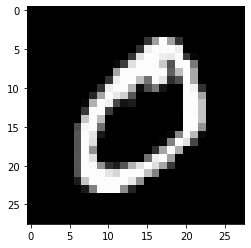

In [0]:
plt.imshow(X_train[1].reshape([28,28]),cmap='gray');

In [0]:
pic1 = X_train[0].reshape([28,28])
pic2 = X_train[1].reshape([28,28])

In [21]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
f = open('/content/drive/My Drive/pim.txt')
pim = f.readline()
pim = pim.split('\t')
pim = np.array(list(map(lambda x: float(x), pim)))
f.close()
f = open('/content/drive/My Drive/nf.txt')
nf = f.readline()
nf = nf.split('\t')
nf = np.array(list(map(lambda x: float(x), nf)))
f.close()
f = open('/content/drive/My Drive/u1.txt')
u1 = f.readline()
u1 = u1.split('\t')
u1 = np.array(list(map(lambda x: float(x), u1)))
f.close()

In [0]:
K = 10
L = 900
N = 900

In [0]:

m1 = pim[:N].reshape((N,1))
m2 = u1[:N].reshape((N,1))

In [0]:

C = np.random.randn(L,N)


h1 = np.random.randn(K,1)
h2 = np.random.randn(K,1)
h3 = np.random.randn(K,1)
h4 = np.random.randn(K,1)

B = np.random.randn(L,K)
#B = np.eye(L,K)
#B2 = np.random.randn(L,K)

In [0]:
A = circulant(C[:,0]) @ B
for iter in range(1,N):
    elem = circulant(C[:,iter]) @ B
    A = np.hstack((A,elem))
#    print(iter)

In [0]:

X11 = h1 @ m1.reshape((1,N))
X12 = h2 @ m1.reshape((1,N))

X1 = np.vstack((X11,X12))

X21 = h3 @ m2.reshape((1,N))
X22 = h4 @ m2.reshape((1,N))

X2 = np.vstack((X21,X22))

In [0]:
X = X1 + X2

In [0]:
a, b = A.shape
A0 = np.zeros((a,b))
A1 = np.hstack((A,A0))
A2 = np.hstack((A0,A))
A = np.vstack((A1,A2))

In [0]:

y =  A @ X.reshape((2*N*K,1)) + nf[:2*N].reshape((2*N,1))

In [0]:

def prox_nuclear(A, lambd):
    U, S, Vh = np.linalg.svd(A)
    svp = np.sum(S > lambd)
    if svp >= 1:
        S = S[:svp] - lambd
        X = U[:,:svp] @ np.diag(S) @ Vh[:svp]
        nucnorm = np.sum(S)
    else:
        X = np.zeros(A.shape)
        nucnorm = 0
    return X, nucnorm

In [0]:
def prox_l21(A,lambd):
    X = np.zeros(A.shape)
    for i in range(X.shape[1]):
        nxi = np.linalg.norm(A[:,i])
        if nxi > lambd:
            X[:,i] = (1 - lambd/nxi) * A[:,i]
    return X
    

In [0]:


def lrr(y, A, lambd):
    tol = 6e-4
    max_iter = 500
    ro = 1.1
    mu = 1e-4
    max_mu = 1e10

    d, na = y.shape
    a, nb = A.shape
    #X = np.zeros((nb, na))
    X = np.zeros((2*K,N))
    E = np.zeros((d, na))
    J = X

    Y1 = E
    Y2 = X
   
    Ablock = A[:int(a/2),:int(nb/2)]

    AtA = Ablock.T @ Ablock
    Aty = A.T @ y
    I = np.eye(int(nb/2))
    invAtAIblock = np.linalg.inv(AtA + I)
    zeros = np.zeros((int(nb/2),int(nb/2)))
   # print(invAtAIblock.shape, zeros.shape)
    invAtAI = np.vstack((np.hstack((invAtAIblock,zeros)), np.hstack((zeros,invAtAIblock))))
  
    errs = []
    times = []
    start = time.time()

    for iter in range(max_iter):
      

        J, nuclearnormJ = prox_nuclear(X+Y2/mu, 1/mu)
        E = prox_l21(y - A @ X.reshape((2*K*N,1)) + Y1/mu, lambd/mu)

        X = (invAtAI @ ((A.T @ (Y1/mu -E) + Aty).reshape((2*K,N)) - Y2/mu + J).reshape((2*K*N,1))).reshape((2*K,N))
        dY1 = y - A @ X.reshape((2*K*N,1)) - E
        dY2 = X - J

        Y1 += mu * dY1
        Y2 += mu * dY2
        mu = min(ro*mu, max_mu)
        times.append(time.time() - start)
       
        metric = np.linalg.norm(y - A @ X.reshape((2*K*N,1)))
        #print(metric)
        errs.append(metric)
        if metric < tol:
            break
    return J, E, errs, iter, times

In [0]:
Xk, E, errs, iters, times = lrr(y, A, 0.01)

In [0]:
u, s, v = np.linalg.svd(Xk)

In [50]:

s

array([9.97031321e-01, 7.39375484e-02, 5.14659024e-02, 4.23796933e-02,
       3.80431081e-02, 3.33582319e-02, 2.61801382e-02, 2.33177090e-02,
       1.69738357e-02, 1.47959592e-02, 9.05706229e-03, 6.10475541e-03,
       2.79039418e-03, 3.24568297e-05, 2.49778638e-05, 9.82655417e-06,
       6.77941152e-06, 4.49061223e-06, 3.50343428e-06, 2.98857303e-06])

In [0]:
signal1 = v[0,:]

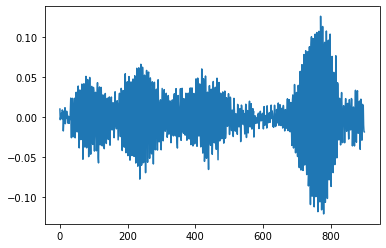

In [53]:
plt.plot(signal1)

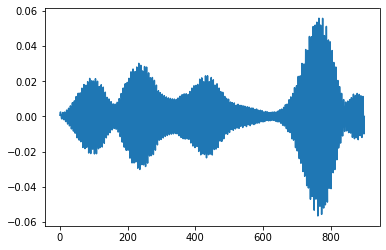

In [64]:
plt.plot(pim[:900])

In [0]:
signal2 = v[1,:]

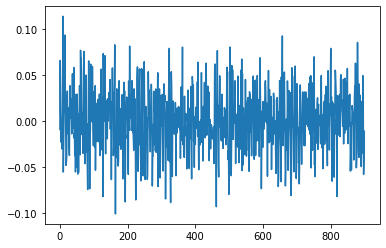

In [55]:
plt.plot(signal2)

In [56]:
times[-1]

79.70885944366455

In [0]:
def sae(s1, s2):
    return np.arccos((s1 @ s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))) ** 2

In [60]:
sae(u1[:900], -v[1,:])

1.0393673182876328

In [63]:
sae(pim[:900], v[0,:])

0.05172403967252702

In [51]:

im1 = (v[0,:]).reshape((28,28))
plt.imshow(im1,'gray')

ValueError: ignored

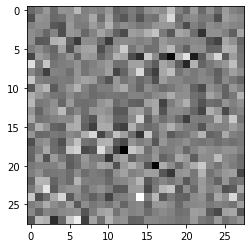

In [0]:
im2 = (v[1,:]).reshape((28,28))
plt.imshow(im2,'gray')

In [0]:
obs = np.v[0,:]

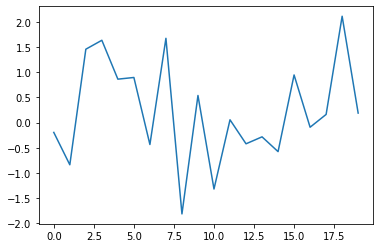

In [0]:
plt.plot(np.vstack((h3,h4)))

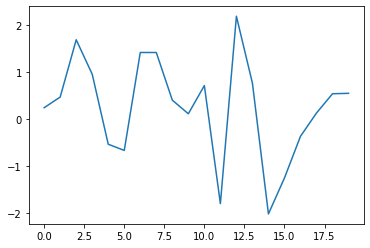

In [0]:
plt.plot(np.vstack((h1,h2)))

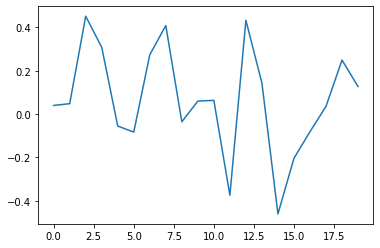

In [0]:

plt.plot(-u[:,0]-0.5*u[:,1])

In [0]:
times

[0.12782621383666992,
 0.276932954788208,
 0.4265773296356201,
 0.5752325057983398,
 0.7291343212127686,
 0.8801007270812988,
 1.0306179523468018,
 1.1796741485595703,
 1.331618070602417,
 1.4806787967681885,
 1.6314032077789307,
 1.7826859951019287,
 1.9374704360961914,
 2.0882761478424072,
 2.2403011322021484,
 2.395017147064209,
 2.559659004211426,
 2.708204984664917,
 2.867178201675415,
 3.0213403701782227,
 3.170931100845337,
 3.319551706314087,
 3.4697701930999756,
 3.6184487342834473,
 3.770854949951172,
 3.9279837608337402,
 4.0805628299713135,
 4.229298830032349,
 4.38348650932312,
 4.534837484359741,
 4.68865704536438,
 4.8418052196502686,
 4.994008541107178,
 5.143083810806274,
 5.292176246643066,
 5.4406578540802,
 5.593298435211182,
 5.742007493972778,
 5.897908687591553,
 6.056574583053589,
 6.209810256958008,
 6.358985185623169,
 6.510350227355957,
 6.660319566726685,
 6.81524920463562,
 6.968506336212158,
 7.130388021469116,
 7.280163049697876,
 7.4324116706848145,
 7.5

In [0]:
def So(tau,X):
    r = np.multiply(np.sign(X) , np.max(np.abs(X) - tau, 0))

    return r

def Do(tau, X):
    U, S, Vh = np.linalg.svd(X)
    add = Vh.shape[1] - len(S)
  
    S_trunc = So(tau, np.diag(S))
    if add > 0:
        zeros = np.zeros((len(S), add))
        S_trunc = np.hstack((S_trunc, zeros))
    r = U @ S_trunc @ Vh
    return r



In [0]:
#https://github.com/dlaptev/RobustPCA/blob/master/RobustPCA.m

def robustPCA(X):

    M, N = X.shape
    normX = np.linalg.norm(X, 'fro')

    lambd = 0.1
    
    #1 / np.sqrt(max(M,N))
  
    mu = 85 * lambd
    tol = 0.0003
    max_iter = 1000

    L = np.zeros((M,N))
    S = np.zeros((M,N))
    Y = np.zeros((M,N))

    for iter in range(max_iter):
        L = Do(1/mu, X - S + (1/mu)*Y)
        S = So(lambd/mu, X - L + (1/mu)*Y)
        Z = X - L - S
        Y = Y + mu*Z
        err = np.linalg.norm(Z, 'fro') / normX
        if err < tol:
            break
        print(err)
    return L, S

In [0]:


Xk1, Xk2 = robustPCA(Xk)

0.01867740236891487
0.025022808750223
0.04251385328686047
0.03745235519485222
0.03447842061265658
0.03961028226753843
0.037517096138261194
0.03645154699798413
0.038103264106916286
0.03832699142103393
0.0368630277944677
0.03731346603000945
0.03839585616352855
0.03772913536342712
0.03749679242414469
0.038594128829848265
0.03828251101477132
0.037523474233158924
0.03825917993268238
0.03841449181085047
0.03779495015173205
0.037981414595135383
0.038721809187609126
0.03845376262118561
0.03821513675076373
0.03895085439792646
0.038726407759362085
0.03805081530604502
0.0385042218320391
0.03896591934693014
0.038408497261881024
0.03841250131993124
0.0386287367504797
0.038289090751554636
0.03856803167610069
0.03904662299746165
0.038551854641439384
0.03821123062692408
0.039038990536105274
0.038642605218466325
0.0383154474656847
0.039589726243132894
0.03913886322903032
0.03756275642984023
0.03892192895809874
0.04008481870528229
0.037968390995368424
0.037818702970868326
0.04073779488968171
0.039294410

In [0]:
ica = FastICA(10)

In [0]:
S_ = ica.fit_transform(X_train[:10].T) 

In [0]:
X_train[:2].shape

(2, 784)

In [0]:
S_.shape

(784, 10)

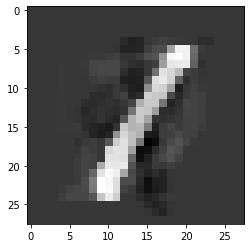

In [0]:
plt.imshow(S_[:,1].reshape(28,28), 'gray')